In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import calcLattice
from calcLattice import make_lattice, reset
import draw
from draw import addTripod, make_figure
%matplotlib inline
import matplotlib as mpl
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from calcLattice import tiles, positions_list, orientations_list, types_list
from calcLattice import gluing_mapping
from symmetry_finding import *
global tiles, positions_list, orientations_list, types_list, gluing_mapping

In [3]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sph_projection_utils import *

In [4]:
gluing_mapping.clear()
# gluing_mapping.update({1:0, 2:0, 3:0}) #monomer
# gluing_mapping.update({1:1, 2:0, 3:0}) #dimer
# gluing_mapping.update({1:2, 2:1, 3:0}) # hexamer

# gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:0, 6:0}) #snow flake
gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:0, 6:6}) #chiral L
# gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:5, 6:0}) #chiral R
# gluing_mapping.update({1:1, 2:2, 3:3, 4:1, 5:5, 6:6}) #lattice without holes

# gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:0, 6:7, 7:6, 8:0, 9:0}) #chiral snowflake
# gluing_mapping.update({1:4, 2:3, 3:2, 4:1, 5:0, 6:7, 7:6, 8:8, 9:0}) # big holes
# gluing_mapping.update({1:1, 2:4, 3:0, 4:2, 5:0, 6:8, 7:9, 8:6, 9:7}) #triangular holes

### Reset tiles, positions_lists, orientations_list, types_list
reset()
make_lattice()

[300]


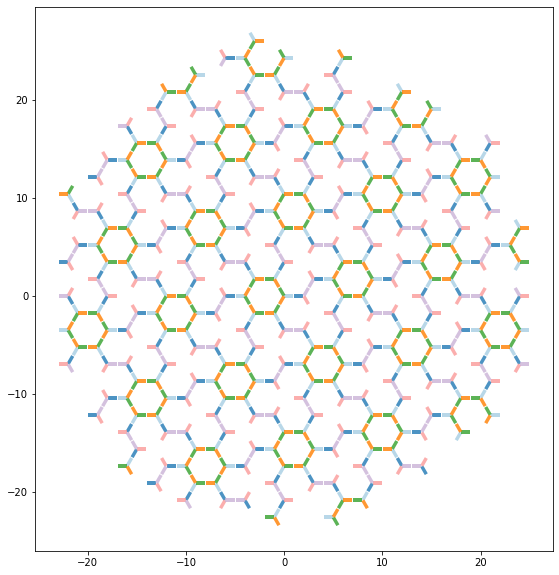

In [5]:
make_figure()
plt.show()

In [7]:
np_pos = np.array(positions_list)

In [8]:
N, _ = np_pos.shape
coords = np.zeros((N, N, 3))
for i, pos in enumerate(np_pos):
    coords[i, :, :2] = np_pos - np_pos[i]

In [9]:
phi, theta = xyz_to_phi_theta(coords)
np.fill_diagonal(phi, 0.)
np.fill_diagonal(theta, 0.)
r = np.linalg.norm(coords, axis=-1)

/Users/hashimpiracha/Desktop/summer_research_2019/linus/linus/sph_projection_utils.py:30: RuntimeWarning:

invalid value encountered in true_divide



In [29]:
ylms_cutoff = np.sum(ylms_within_r_cutoff(coords, 7.0)[0], axis=-1)

/Users/hashimpiracha/Desktop/summer_research_2019/linus/linus/sph_projection_utils.py:30: RuntimeWarning:

invalid value encountered in true_divide



In [30]:
local_cutoff_norms = norm_sph(ylms_cutoff.T)

In [45]:
(kmeans_sph, sph_colors), (kmeans_norm, norms_colors) = get_sph_and_norm_clusters(
    coords, 3.0, n_clusters_sph=10, n_clusters_norm=6)

/Users/hashimpiracha/Desktop/summer_research_2019/linus/linus/sph_projection_utils.py:30: RuntimeWarning:

invalid value encountered in true_divide



In [46]:
sph_clusters = {k: [] for k in range(20)}
for k,v in zip(sph_colors, np_pos):
    sph_clusters[k].append(v)

norms_clusters = {k: [] for k in range(10)}
for k,v in zip(norms_colors, np_pos):
    norms_clusters[k].append(v)

In [47]:
diff_vect_dict, diff_pairs_dict = get_cluster_function(sph_clusters, lambda a,b: a - b)
midpoint_dict, mid_pairs_dict = get_cluster_function(norms_clusters, lambda a,b: (a + b) / 2.)

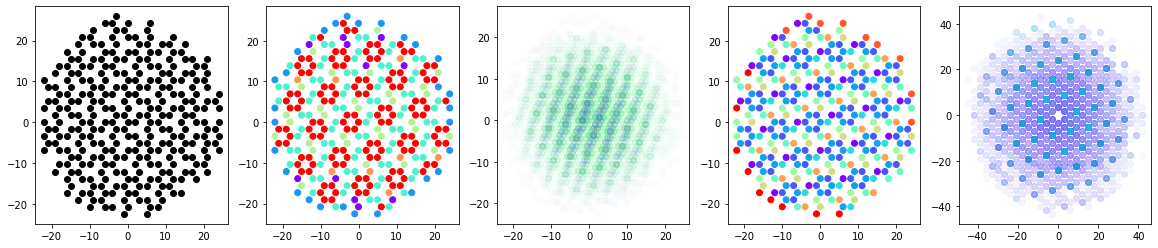

In [48]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
axes[0].plot(np_pos[:, 0].tolist(), np_pos[:, 1].tolist(), 'ko')
axes[1].scatter(np_pos[:, 0].tolist(), np_pos[:, 1].tolist(), c=norms_colors, cmap=cm.rainbow)
axes[3].scatter(np_pos[:, 0].tolist(), np_pos[:, 1].tolist(), c=sph_colors, cmap=cm.rainbow)
# Get translation vector between sph clusters (identical spherical harmonics)
for i, (cluster, diff_vectors) in enumerate(diff_vect_dict.items()):
    diff_vectors = np.array(diff_vectors)
    if len(diff_vectors) > 0:
        axes[4].plot(diff_vectors[:,0], diff_vectors[:,1],'o', alpha=0.05, color=cm.rainbow(i/20))
#     axes[3].plot(np_pos[:,0], np_pos[:,1], 'ko')
# mid_points = []
for i, (cluster, mid_points) in enumerate(midpoint_dict.items()):
    mid_points = np.array(mid_points)
    if len(mid_points) > 0:
        axes[2].plot(mid_points[:,0], mid_points[:,1],'o', alpha=0.01, color=cm.rainbow(i/10))
#     axes[1].plot(np_pos[:,0], np_pos[:,1], 'ko')

In [ ]:
# TODO: Keep track of pointers for lattice and mid points
# TODO: Use pointers and radial cutoff to define clusters of points that have symmetry axis (within and beyond single cluster)
# TODO: Use pick conventional lattice vectors and center and get spacegroup symmetry (or plane group -- ?)
# TODO: Use symmetry axes and cutoff radius information to iteratively define "motifs"
# TODO: Define some motif descriptor as a function of cutoff radius (will have jumps)


# TODO: symmetry axes currently are detected for motifs that are much larger than span of spherical harmonics than a given motif
# Should we play with this?
# Simplest output:
# + output motifs of given cluster (sph and norm clusters)
# Adjacent output:
# + define symmetry axes of motif
# + adjacent points (even outside of cluster) that have same translation vectors (given a seed point) 
# -- actually, no good terminating condition so nvm
# Harder (but doable) output:
# + define lattice vectors -- the hard part is checking the lattice (?)

# Okay, so really we want viable tool for hashing patterns

In [46]:
def bin_points_by_weight_and_location(points, tolerance=1e-3):
    # Seed bins with points (may want to randomize for stability)
    cluster_dicts = {}
    for i, point in enumerate(points):
        point_added = False
        for key in cluster_dicts:
            if np.linalg.norm(np.abs(points[key] - point)) < tolerance:
                cluster_dicts[key].append(i)
                point_added = True
                break
        if not point_added:
            cluster_dicts.update({i: [i]})
    return cluster_dicts
        

In [79]:
lattice_points = []
for value in diff_vect_dict.values():
    if len(value) > 0:
        lattice_points += value
        
symm_points = []
for value in midpoint_dict.values():
    if len(value) > 0:
        symm_points += value

In [61]:
def sort_keys_by_len_values(dict, reversed=False):
    sign = 1 if not reversed else -1
    keys_weights = []
    for key, value in sorted(dict.items(), key=lambda x: (sign * len(x[1]), x[0])):
        keys_weights.append((key, len(value)))
    return keys_weights

In [ ]:
def sort_keys_by_len_and_norm(dict, reversed=False):
    pass

In [64]:
result = bin_points_by_weight_and_location(lattice_points)
key_weights = sort_keys_by_len_values(result, reversed=True)

In [81]:
result = bin_points_by_weight_and_location(symm_points)
symm_key_weights = sort_keys_by_len_values(result, reversed=True)

In [82]:
len(symm_points)

11371

In [73]:
lattice_candidates = np.array([lattice_points[k] for k,v in key_weights[:20]])

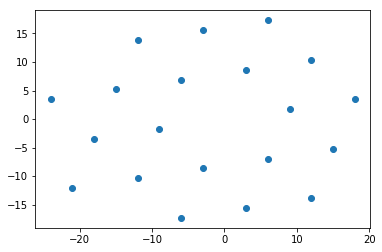

In [75]:
plt.plot(lattice_candidates[:,0], lattice_candidates[:,1],'o')